In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import os
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym
import yaml

from minatar_dqn.replay_buffer import ReplayBuffer
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization
from experiments.experiment_utils import (
    collect_training_output_files,
    collect_pruning_output_files,
)

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
import scipy

sns.set()

import plotly

plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
training_timestamp_folder = "2023_10_26-22_11_20"
envs_to_keep = ["breakout"]

In [42]:
training_outputs_folder_path = (
    r"D:\Work\repos\RL\minatar_work\experiments\training\outputs"
)

experiment_paths = collect_training_output_files(
    os.path.join(training_outputs_folder_path, training_timestamp_folder)
)


def get_records_from_training_experiment(experiment_files, stats_type="validation"):
    checkpoint = torch.load(experiment_files["stats_path"])

    training_stats = checkpoint["training_stats"]
    validation_stats = checkpoint["validation_stats"]

    if stats_type == "training":
        flat_records = process_records_from_stats_and_config(
            training_stats, experiment_files["config_path"], stats_type
        )
    elif stats_type == "validation":
        flat_records = process_records_from_stats_and_config(
            validation_stats, experiment_files["config_path"], stats_type
        )

    return flat_records


def process_records_from_stats_and_config(stats, config_path, stats_type):
    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")
        flat_stats["epoch_type"] = stats_type
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of
    # exp name in config
    config_file_name = os.path.basename(config_path)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["experiment_name"] = config["experiment_name"]

    return flat_records


def collect_training_experiment_results(
    experiment_paths, stats="validation", train_epoch_counter=200_000
):
    records = []
    for experiment_files in experiment_paths:
        if experiment_files:  # in case experiment did not finish
            records.extend(
                get_records_from_training_experiment(experiment_files, stats_type=stats)
            )

    df = pd.DataFrame.from_records(records)
    df["epoch"] = df["frame_stamp"] // train_epoch_counter

    return df


df = collect_training_experiment_results(experiment_paths, stats="validation")
# df = collect_training_experiment_results(experiment_paths, stats="training")

print(df.shape)
df.head()

df["model_name"] = df["experiment_name"].map(lambda x: "_".join(x.split("_")[0:2]))
# df["model_name"]

D:\Work\repos\RL\minatar_work\experiments\training\outputs\2023_10_26-22_11_20
(120, 24)


In [44]:
df.columns

Index(['frame_stamp', 'episode_rewards_min', 'episode_rewards_max',
       'episode_rewards_mean', 'episode_rewards_median', 'episode_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'epoch_time', 'reward_contor_0',
       'reward_contor_1', 'epoch_type', 'environment', 'seed',
       'experiment_name', 'epoch', 'model_name'],
      dtype='object')

In [45]:
def get_redo_type(x):
    if "redo" in x:
        return "_".join(x.split("_")[-2:])
    else:
        return "no_redo"
    
df["redo_type"] = df["experiment_name"].map(get_redo_type)

In [46]:
df["redo_type"].unique()

array(['no_redo', 'redo_intersect', 'redo_normal', 'redo_union'],
      dtype=object)

In [47]:
df

,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,epoch_time,reward_contor_0,reward_contor_1,epoch_type,environment,seed,experiment_name,epoch,model_name,redo_type
0,200000,0.0,7.0,2.580785,2.0,1.231701,6,82,33.831123,28.0,...,0 days 00:01:18.654882,115470,9536,validation,breakout,0,conv32_lin128,1,conv32_lin128,no_redo
1,400000,0.0,9.0,4.093127,5.0,1.954096,6,102,50.836926,58.0,...,0 days 00:01:21.595024,114943,10065,validation,breakout,0,conv32_lin128,2,conv32_lin128,no_redo
2,600000,0.0,9.0,4.851570,5.0,1.529863,6,102,59.492864,62.0,...,0 days 00:01:19.735711,114856,10198,validation,breakout,0,conv32_lin128,3,conv32_lin128,no_redo
3,800000,0.0,13.0,6.023823,7.0,2.458850,6,148,70.955190,82.0,...,0 days 00:01:24.297193,114474,10620,validation,breakout,0,conv32_lin128,4,conv32_lin128,no_redo
4,1000000,0.0,20.0,8.966140,8.0,5.788047,6,192,94.120391,96.0,...,0 days 00:01:23.564247,113170,11916,validation,breakout,0,conv32_lin128,5,conv32_lin128,no_redo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2200000,0.0,23.0,7.829215,8.0,2.757240,6,242,90.902616,95.0,...,0 days 00:01:00.869541,114309,10773,validation,breakout,0,conv64_lin256_redo_union,11,conv64_lin256,redo_union
116,2400000,0.0,19.0,8.956962,9.0,2.901593,6,180,105.513924,110.0,...,0 days 00:01:00.886277,114420,10614,validation,breakout,0,conv64_lin256_redo_union,12,conv64_lin256,redo_union
117,2600000,0.0,18.0,6.708597,7.0,2.129894,6,174,79.077118,82.0,...,0 days 00:01:01.247894,114487,10613,validation,breakout,0,conv64_lin256_redo_union,13,conv64_lin256,redo_union
118,2800000,0.0,20.0,8.984861,10.0,3.233254,6,198,105.140454,116.0,...,0 days 00:01:00.301242,114329,10683,validation,breakout,0,conv64_lin256_redo_union,14,conv64_lin256,redo_union


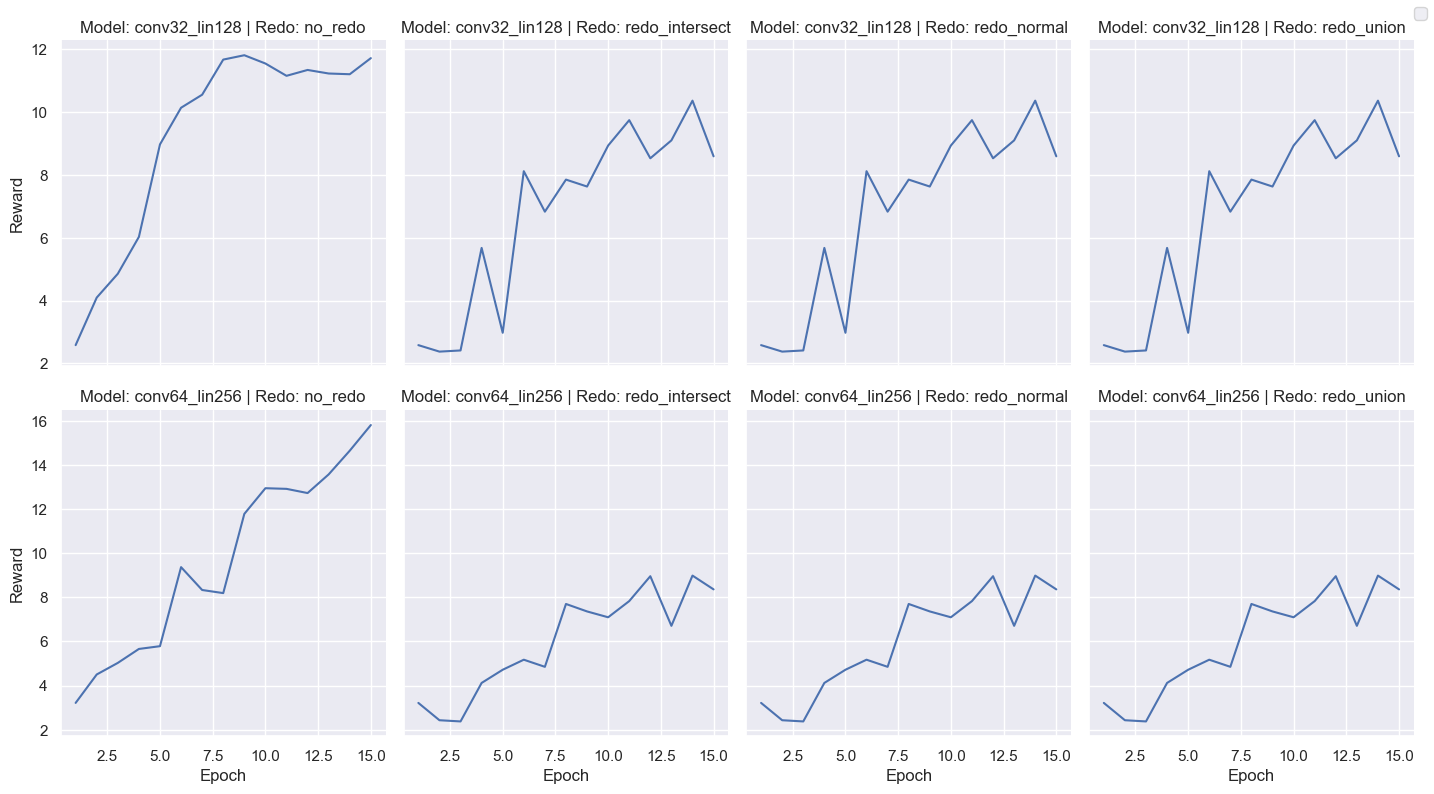

In [48]:
# All displayed on top of facet

model_order = ["conv32_lin128", "conv64_lin256"]

sub_df = df[df["environment"].isin(envs_to_keep)]
g = sns.FacetGrid(sub_df, row='model_name', col='redo_type', height=4, aspect=0.9, sharey="row", row_order=model_order)

g.map(sns.lineplot, 'epoch', 'episode_rewards_mean')

font_dict = {'fontsize': 'small'}  # Adjust this as needed.
g.set_titles(col_template="Redo: {col_name}", row_template="Model: {row_name}", fontdict=font_dict)
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [50]:
pruning_outputs_folder_path = (
    r"D:\Work\repos\RL\minatar_work\experiments\pruning\outputs"
)
pruning_timestamp_folder = training_timestamp_folder

experiment_paths = collect_pruning_output_files(
    os.path.join(pruning_outputs_folder_path, pruning_timestamp_folder)
)

In [57]:
def process_pruning_stats_file(file):
    checkpoint = torch.load(file)

    exp_stats = checkpoint["pruning_validation_results"]
    exp_info = checkpoint["experiment_info"]

    records = []
    for pruning_value in exp_stats:
        stats = exp_stats[pruning_value]
        stats["pruning_value"] = pruning_value
        stats["pruning_method"] = os.path.basename(file).split("_")[-1]
        stats["experiment_info"] = exp_info
        records.append(stats)

    return records


def add_baseline_stats(baseline_file, file):
    """Add a new record with the baseline stats and an associated
    pruning_method just to make data aggregation easier."""
    checkpoint = torch.load(baseline_file)
    baseline_stats = checkpoint["pruning_validation_results"]
    baseline_info = checkpoint["experiment_info"]

    records = []
    for pruning_value in baseline_stats:
        stats = baseline_stats[pruning_value]
        stats["pruning_value"] = pruning_value
        stats["pruning_method"] = os.path.basename(file).split("_")[-1]
        stats["experiment_info"] = baseline_info

        records.append(stats)

    return records


def get_records_from_pruning_experiment(experiment_files):
    config_path = experiment_files["config_path"]

    stats = []
    for file in experiment_files["pruning_stats_paths"]:
        stats.extend(process_pruning_stats_file(file))
        stats.extend(add_baseline_stats(experiment_files["baseline_stats_path"], file))

    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of
    # exp name in config
    config_file_name = os.path.basename(config_path)
    exp_name_tokens = config_file_name.split("_")[:2]
    exp_name = "_".join(exp_name_tokens)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["model_name"] = exp_name
        record["experiment_name"] = config["experiment_name"]

    return flat_records


def collect_pruning_experiment_results(experiment_paths):
    records = []
    for experiment_files in experiment_paths:
        records.extend(get_records_from_pruning_experiment(experiment_files))

    df = pd.DataFrame.from_records(records)
    # df["epoch"] = df["frame_stamp"] // train_epoch_counter

    return df


df = collect_pruning_experiment_results(experiment_paths)

pruning_method_nr_to_name = {
    "1": "prune_middle",
    "2": "prune_features",
    "3": "prune_all",
    "4": "s_prune_conv",
}

# Map the 'fruit' column to 'color'
df["pruning_method"] = df["pruning_method"].map(pruning_method_nr_to_name)

df["redo_type"] = df["experiment_name"].map(get_redo_type)

df.head()

,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,reward_contor_0,reward_contor_1,pruning_value,pruning_method,experiment_info,environment,seed,model_name,experiment_name,redo_type
0,0,0.0,23.0,11.443487,11.0,5.578735,6,224,119.846743,130.0,...,113173,11947,0.05,prune_middle,\n Prune the second convolutional layer and...,breakout,0,conv32_lin128,conv32_lin128,no_redo
1,0,0.0,22.0,11.650532,11.0,5.680152,6,186,121.059051,130.0,...,113019,12035,0.10,prune_middle,\n Prune the second convolutional layer and...,breakout,0,conv32_lin128,conv32_lin128,no_redo
2,0,0.0,23.0,11.449761,11.0,5.640643,6,212,119.651675,130.0,...,113071,11965,0.15,prune_middle,\n Prune the second convolutional layer and...,breakout,0,conv32_lin128,conv32_lin128,no_redo
3,0,0.0,24.0,11.325382,11.0,5.444379,6,232,119.356870,130.0,...,113217,11869,0.20,prune_middle,\n Prune the second convolutional layer and...,breakout,0,conv32_lin128,conv32_lin128,no_redo
4,0,0.0,22.0,11.530259,11.0,5.710877,6,186,120.122959,130.0,...,113045,12003,0.30,prune_middle,\n Prune the second convolutional layer and...,breakout,0,conv32_lin128,conv32_lin128,no_redo


In [67]:
def normalize_df_using_baseline_single_env(df):
    cols_to_not_normalize = [
        "frame_stamp",
        "epoch_time",
        "pruning_value",
        "pruning_method",
        "experiment_info",
        "environment",
        "seed",
        "model_name",
    ]

    # Find the baseline values
    baseline = df[(df["pruning_value"] == 0)]

    groups = df.groupby(["model_name", "seed"])

    for (model_name, seed), group in groups:
        for metric in group.columns.difference(cols_to_not_normalize):
            # Get the baseline value for this metric and model/seed/pruning_method combination
            baseline_value = baseline[
                (baseline["model_name"] == model_name) & (baseline["seed"] == seed)
            ][metric].iloc[0]

            # Normalize the values for this metric by the baseline value
            group[metric] /= baseline_value

            # Store the normalized values back in the original DataFrame
            df.loc[group.index, metric] = group[metric]

    return df


def normalize_df_using_baseline_all_envs(df):
    cols_to_not_normalize = [
        "frame_stamp",
        "epoch_time",
        "pruning_value",
        "pruning_method",
        "experiment_info",
        "environment",
        "seed",
        "model_name",
    ]

    # Find the baseline values
    baseline = df[(df["pruning_value"] == 0)]

    groups = df.groupby(["environment", "model_name", "seed"])

    for (environment, model_name, seed), group in groups:
        for metric in group.columns.difference(cols_to_not_normalize):
            # Get the baseline value for this metric and model/seed/pruning_method combination
            baseline_value = baseline[
                (baseline["environment"] == environment)
                & (baseline["model_name"] == model_name)
                & (baseline["seed"] == seed)
            ][metric].iloc[0]

            # Normalize the values for this metric by the baseline value
            print(metric, baseline_value)
            group[metric] /= baseline_value

            # Store the normalized values back in the original DataFrame
            df.loc[group.index, metric] = group[metric]

    return df


def plot_facetgrid_experiment(
    df, y_label="Mean score", title="Mean score at different levels of pruning"
):
    experiment_order = ["conv8_lin32", "conv16_lin64", "conv32_lin128", "conv64_lin256"]

    # Compute the average metric between the seeds for each experiment
    # avg_df = df.groupby(['environment', 'experiment_name', 'epoch']).mean().reset_index()

    g = sns.FacetGrid(
        df,
        row="pruning_method",
        col="model_name",
        col_order=experiment_order,
        height=3,
        aspect=1,
        sharey="row",
    )
    g.map(sns.lineplot, "pruning_value", "episode_rewards_mean")

    # Set the plot title and axis labels
    g.fig.suptitle(title)
    g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=1)

    g.figure.subplots_adjust(top=0.9, wspace=0.1)
    g.set_axis_labels("Pruning factor", y_label)


def plot_facetgrid_experiment_common_titles(
    df, y_label="Mean score", title="Mean score at different levels of pruning"
):
    experiment_order = ["conv8_lin32", "conv16_lin64", "conv32_lin128", "conv64_lin256"]

    # Compute the average metric between the seeds for each experiment
    # avg_df = df.groupby(['environment', 'experiment_name', 'epoch']).mean().reset_index()

    g = sns.FacetGrid(
        df,
        row="pruning_method",
        col="model_name",
        col_order=experiment_order,
        height=3,
        aspect=1,
        sharey="row",
    )
    g.map(sns.lineplot, "pruning_value", "episode_rewards_mean")

    # Set the plot title and axis labels
    g.fig.suptitle(title)
    g.set_titles("")  # Clear default titles

    # Set labels for x and y axes
    g.set_axis_labels("Pruning factor", y_label)

    # Shared row titles on the right of last column
    # for i, ax in enumerate(g.axes[:, -1]):  # Targeting the last column of axes
    # ax.yaxis.set_label_position("right")
    # ax.set_ylabel(g.row_names[i], fontsize=14, rotation=-90, va="center")  # Adjust the size as per your requirement

    # Label the rows with their respective environment, rotated and moved to the right of the last column
    for i, ax in enumerate(g.axes[:, -1]):  # Targeting the last column of axes
        ax.text(
            1.05,
            0.5,
            g.row_names[i],
            rotation=-90,
            va="center",
            ha="center",
            transform=ax.transAxes,
            fontsize=18,
        )

    # Shared column titles on top
    for i, ax in enumerate(g.axes[0]):  # Targeting the top row of axes
        ax.set_title(
            experiment_order[i], fontsize=18
        )  # Adjust the size as per your requirement

    # Adjust layout for better appearance
    g.figure.subplots_adjust(top=0.9, wspace=0.1, hspace=0.3)

    plt.tight_layout()
    plt.show()

In [68]:
# MARK: needed for poster

sub_df = df.copy(deep=True)
sub_df = sub_df[sub_df["model_name"].isin(["conv32_lin128", "conv64_lin256"])]
sub_df = sub_df[sub_df["environment"].isin(envs_to_keep)]
sub_df = normalize_df_using_baseline_all_envs(sub_df)

plot_facetgrid_experiment_common_titles(
    sub_df,
    y_label="Normalized score",
    title=f"Normalized mean score at different levels of pruning (All envs aggregated)",
)

# Show the plot
plt.show()

episode_frames_max 192
episode_frames_mean 123.95044598612488
episode_frames_median 130.0
episode_frames_min 6
episode_frames_std 41.9416925284371
episode_max_qs_max -13.031120300292969
episode_max_qs_mean -44.40231044302737
episode_max_qs_median -38.62165069580078
episode_max_qs_min -122.41806030273438
episode_max_qs_std 22.10723034201731
episode_rewards_max 22.0
episode_rewards_mean 12.025768087215065
episode_rewards_median 11.0
episode_rewards_min 0.0
episode_rewards_std 5.773159077843742
experiment_name conv32_lin128


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [34]:
def mask_to_score_distance(mask, scores):
    num_ones = np.count_nonzero(mask)

    if num_ones == 0:
        return 0

    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)

    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True

    # Calculate the Hamming distance between the masks
    hamming_distance = torch.sum(torch.logical_and(mask, new_mask))
    hamming_relative_distance = hamming_distance.item() / len(mask)

    return hamming_relative_distance


def mask_vs_norm_stats(mask, scores):
    num_ones = np.count_nonzero(mask)

    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)

    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True

    # Calculate the Hamming distance between the masks
    only_redo = torch.sum(torch.logical_and(mask, torch.eq(new_mask, False))).item()
    intersect = torch.sum(torch.logical_and(mask, new_mask)).item()
    only_pruning = torch.sum(torch.logical_and(torch.eq(mask, False), new_mask)).item()

    return only_redo, intersect, only_pruning


def get_rankings(scores):
    sorted_indices = torch.argsort(scores)

    # Initialize tensor for rankings
    rankings = torch.zeros_like(scores, dtype=torch.long)

    # Assign ranks to scores
    rankings[sorted_indices] = torch.arange(1, len(scores) + 1)

    return rankings


def compare_redo_pruning(exp_paths):
    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        # Build a new model
        validation_env = build_environment(cfg["environment"], cfg["seed"])

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(
            in_features=in_features,
            in_channels=in_channels,
            num_actions=num_actions,
            **cfg["estimator"]["args_"]
        )
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(
            checkpoint_models_state["policy_model_state_dict"]
        )
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = get_rankings(l1_norms)

            check_index = (
                int(os.path.basename(checkpoint_path).split("_")[1]) - 1
            )  # get the index of the checkpoint

            redo_score = redo_scores[check_index][i]
            redo_rankings = get_rankings(torch.tensor(redo_score))

            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

            # also do an experiment with thresholding

            tau_vals = [0.025, 0.1]

            for tau in tau_vals:
                dormant_neurons_mask = redo_score <= tau

                dormant_neurons_idx = dormant_neurons_mask.nonzero().flatten()

                only_redo, intersect, only_pruning = mask_vs_norm_stats(
                    dormant_neurons_mask, l1_norms
                )

                new_row = {
                    "seed": cfg["seed"],
                    "env": cfg["environment"],
                    "experiment": "_".join(
                        cfg["experiment_name"].split("_")[:2]
                    ),  # WARNING
                    "tau": tau,
                    "nr_only_redo": only_redo,
                    "nr_intersect": intersect,
                    "nr_only_pruning": only_pruning,
                    "dead_neuron_l1norms": l1_norms[dormant_neurons_idx],
                    "dead_neuron_l1norms_avg": np.average(
                        l1_norms[dormant_neurons_idx]
                    ),
                    "dead_neuron_ratio": len(dormant_neurons_idx) / len(redo_score),
                    "redo_l1norm_hamming": mask_to_score_distance(
                        dormant_neurons_mask, l1_norms
                    ),
                    "checkpoint": os.path.basename(checkpoint_path),
                    "epoch": check_index,
                    "layer": layer_key,
                    "kendall_r_corr": k_corr,
                    "kendall_r_pval": k_pval,
                    "spearman_r_corr": s_corr,
                    "spearman_r_pval": s_pval,
                    "pearson_corr": p_corr,
                    "pearson_pval": p_pval,
                }
                results.append(new_row)

    df = pd.DataFrame(results)

    return df

In [35]:
# Collect all paths to models in a specified folder
training_outputs_folder_path = os.path.join(
    proj_root, "experiments", "training", "outputs"
)
pruning_outputs_folder_path = os.path.join(
    proj_root, "experiments", "pruning", "outputs"
)

experiments_folder = os.path.join(
    training_outputs_folder_path, training_timestamp_folder
)

experiment_paths = collect_training_output_files(
    os.path.join(training_outputs_folder_path, training_timestamp_folder)
)

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])

exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))

# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

d:\Work\repos\RL\minatar_work\experiments\training\outputs\2023_10_26-22_11_20


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_32120\4083292704.py:110: UserWarning:

To copy construct from 

,seed,env,experiment,tau,nr_only_redo,nr_intersect,nr_only_pruning,dead_neuron_l1norms,dead_neuron_l1norms_avg,dead_neuron_ratio,redo_l1norm_hamming,checkpoint,epoch,layer,kendall_r_corr,kendall_r_pval,spearman_r_corr,spearman_r_pval,pearson_corr,pearson_pval
0,0,breakout,conv32_lin128,0.025,8,7,8,"[tensor(5.2725), tensor(7.1313), tensor(5.8596...",5.660014,0.468750,0.218750,mck_1,0,features.0.weight,-0.028226,8.343999e-01,-0.068182,7.108004e-01,-0.129287,4.806682e-01
1,0,breakout,conv32_lin128,0.100,0,32,0,"[tensor(5.2725), tensor(6.3279), tensor(5.1877...",5.581620,1.000000,1.000000,mck_1,0,features.0.weight,-0.028226,8.343999e-01,-0.068182,7.108004e-01,-0.129287,4.806682e-01
2,0,breakout,conv32_lin128,0.025,1,0,1,[tensor(24.4055)],24.405518,0.031250,0.000000,mck_1,0,features.2.weight,0.165323,1.905990e-01,0.237903,1.898040e-01,0.607382,2.274038e-04
3,0,breakout,conv32_lin128,0.100,0,32,0,"[tensor(24.4286), tensor(23.4283), tensor(25.0...",25.009521,1.000000,1.000000,mck_1,0,features.2.weight,0.165323,1.905990e-01,0.237903,1.898040e-01,0.607382,2.274038e-04
4,0,breakout,conv32_lin128,0.025,3,107,3,"[tensor(16.6022), tensor(17.7833), tensor(17.0...",23.476021,0.859375,0.835938,mck_1,0,fc.0.weight,0.578494,3.498070e-22,0.764890,7.911225e-26,0.945896,1.916674e-63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0,breakout,conv64_lin256,0.100,0,64,0,"[tensor(3.9821), tensor(11.9900), tensor(9.893...",6.152067,1.000000,1.000000,mck_9,8,features.0.weight,0.227183,7.966674e-03,0.369643,2.646131e-03,0.706111,7.152227e-11
86,0,breakout,conv64_lin256,0.025,5,51,5,"[tensor(28.1476), tensor(20.0419), tensor(18.5...",22.560787,0.875000,0.796875,mck_9,8,features.2.weight,0.078373,3.599857e-01,0.110073,3.865638e-01,0.285842,2.204080e-02
87,0,breakout,conv64_lin256,0.100,0,64,0,"[tensor(28.1476), tensor(20.0419), tensor(18.5...",22.592314,1.000000,1.000000,mck_9,8,features.2.weight,0.078373,3.599857e-01,0.110073,3.865638e-01,0.285842,2.204080e-02
88,0,breakout,conv64_lin256,0.025,0,249,0,"[tensor(88.4549), tensor(70.7537), tensor(23.8...",73.199074,0.972656,0.972656,mck_9,8,fc.0.weight,0.130208,1.910704e-03,0.214090,5.631881e-04,0.886116,8.296041e-87


Text(0.5, 0.98, 'dead_neuron_ratio')

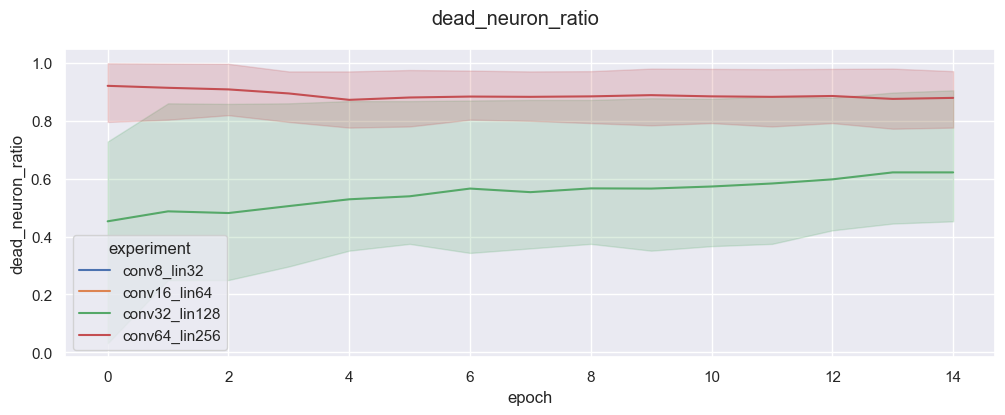

In [36]:
metric_col = "dead_neuron_ratio"

experiment_order = ["conv8_lin32", "conv16_lin64", "conv32_lin128", "conv64_lin256"]

sub_df = df_res[df_res["tau"] == 0.025]
sub_df = sub_df[sub_df["env"].isin(envs_to_keep)]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(["env", "experiment", "epoch", "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(
    avg_df, x="epoch", y=metric_col, hue="experiment", hue_order=experiment_order, ax=ax
)

fig.suptitle(metric_col)

In [37]:
experiment_order = ["conv8_lin32", "conv16_lin64", "conv32_lin128", "conv64_lin256"]

for layer in df_res["layer"].unique():
    sub_df = df_res[(df_res["tau"] == 0.025) & (df_res["layer"] == layer)]
    sub_df = sub_df[sub_df["env"].isin(envs_to_keep)]

    # melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
    #                         value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
    #                         var_name='Category', value_name='Value')

    # fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment",
    #             category_orders={"experiment": experiment_order},
    #             height=600)

    # title = f"Redo and Norm overlap - Layer {layer} shared Y"
    # file_path = f"imgs/{title}.png"

    # # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    # fig.update_layout(title=title)
    # fig.show()

    melted_df = sub_df.melt(
        id_vars=["env", "experiment", "epoch"],
        value_vars=["nr_only_redo", "nr_intersect", "nr_only_pruning"],
        var_name="Category",
        value_name="Value",
    )

    melted_df = melted_df.rename(columns={"Value": "Nr. Neurons"})
    melted_df["Category"] = melted_df["Category"].replace(
        {
            "nr_only_redo": "Only Redo",
            "nr_intersect": "Intersect",
            "nr_only_pruning": "Only Pruning",
        }
    )

    fig = px.bar(
        melted_df,
        x="epoch",
        y="Nr. Neurons",
        color="Category",
        facet_row="env",
        facet_col="experiment",
        category_orders={"experiment": experiment_order},
        height=600,
        width=1500,
    )

    fig.update_yaxes(matches=None, showticklabels=True)

    title = f"Redo and Norm overlap - Layer {layer}"
    file_path = f"imgs/{title}.png"

    # Save the figure as a PNG image
    pio.write_image(fig, file_path)

    fig.update_layout(
        title=title,
        title_font=dict(size=24),  # Adjust the size as per your requirement
        legend_title_font=dict(size=18),  # Adjust the size as per your requirement
        legend_font=dict(size=16),  # Adjust the size as per your requirement
    )

    # Update row and column facet font sizes
    for annotation in fig.layout.annotations:
        annotation.font.size = 18

    fig.show()